In [1]:
import os
import numpy as np
import math
import random
from torch.utils.data import Dataset, DataLoader
import torch
from imgaug import augmenters as iaa
from PIL import Image  # Import PIL
import cv2  # Keep cv2 for certain functions that PIL doesn't support

def warp_image(img, pts_src, pts_dst):

    # try rgb
    try:
        height, width, _ = img.shape
    # try grayscale
    except ValueError:
        height, width = img.shape

    #  Calculate Homography
    h, status = cv2.findHomography(pts_src, pts_dst)

    #  Warp source image to destination based on homography; format (4,2)
    return cv2.warpPerspective(src=img, M=h, dsize=(width, height))

class SyntheticDataset(Dataset):
    """
    Synthetic Dataset Generation for PyTorch DataLoader.
    """

    def __init__(self, input_path, background_path, target_dims=(330, 256),
                 shift=100, p=1, transform=None, grayscale=False, normalize=True):
        self.input_dir = input_path
        self.backgrounds_dir = background_path
        self.target_dims = target_dims
        self.shift = shift
        self.p = p
        self.transform = transform
        self.grayscale = grayscale
        self.normalize = normalize

        # Get list of document images and backgrounds
        self.doc_imgs = [f for f in os.listdir(self.input_dir) if self.is_image_file(f)]
        self.backgrounds = [f for f in os.listdir(self.backgrounds_dir) if self.is_image_file(f)]

        if len(self.doc_imgs) == 0:
            raise ValueError(f"No images found in input directory: {self.input_dir}")
        if len(self.backgrounds) == 0:
            raise ValueError(f"No images found in backgrounds directory: {self.backgrounds_dir}")

    def __len__(self):
        return len(self.doc_imgs) * 100  # Adjust as needed

    def __getitem__(self, idx):
        # Retrieve a random document image and background
        random_img_nm = random.choice(self.doc_imgs)
        random_background = random.choice(self.backgrounds)

        # Read and resize document image using PIL
        img_path = os.path.join(self.input_dir, random_img_nm)
        img = Image.open(img_path)
        img = img.resize((self.target_dims[1], self.target_dims[0]), Image.Resampling.LANCZOS)
        img = np.array(img)  # Convert PIL image to NumPy array

        if img is None:
            raise FileNotFoundError(f"Image not found: {img_path}")

        if img.ndim == 2:
            img = np.stack((img,)*3, axis=-1)  # Convert grayscale to RGB

        height, width, _ = img.shape

        # Augment sample
        mode = np.random.choice([0, 1], p=[self.p, 1 - self.p])
        warped_image, y = self.augment_sample(img=img, mode=mode, background=random_background)

        # Convert to grayscale if required
        if self.grayscale:
            warped_image = cv2.cvtColor(warped_image, cv2.COLOR_BGR2GRAY)
            warped_image = np.expand_dims(warped_image, axis=-1)

        # Normalize
        if self.normalize:
            warped_image = warped_image.astype(np.float32) / 255.0
        else:
            warped_image = warped_image.astype(np.float32)

        # Convert image to channel-first format
        if self.grayscale:
            warped_image = np.transpose(warped_image, (2, 0, 1))  # (1, H, W)
        else:
            warped_image = np.transpose(warped_image, (2, 0, 1))  # (3, H, W)

        # Convert to torch tensors
        image_tensor = torch.tensor(warped_image, dtype=torch.float32)
        homography_tensor = torch.tensor(y, dtype=torch.float32)

        # Apply any additional transforms
        if self.transform:
            image_tensor = self.transform(image_tensor)

        return image_tensor, homography_tensor

    @staticmethod
    def is_image_file(filename):
        img_extensions = ['.png', '.jpg', '.jpeg', '.bmp', '.tiff', '.gif']
        return any(filename.lower().endswith(ext) for ext in img_extensions)

    def augment_sample(self, img, mode, background):
        # Perspective transformation
        warped_image, y = self.augment_perspective(img, mode)

        # Background transformation
        background_img = self.augment_background(background)

        # Handle alpha channel if present
        if warped_image.shape[2] == 4:
            # Split alpha channel
            alpha = warped_image[:, :, 3] / 255.0
            alpha = np.expand_dims(alpha, axis=2)
            # Composite the warped image with the background
            warped_image = warped_image[:, :, :3] * alpha + background_img[:, :, :3] * (1 - alpha)
            warped_image = warped_image.astype(np.uint8)
        else:
            # If no alpha channel, assume warped_image covers the background
            warped_image = warped_image

        # Photometric transformations
        warped_image = self.augment_photometric(warped_image)

        return warped_image, y

    def augment_perspective(self, img, mode):
        # Ensure the image has an alpha channel
        if img.shape[2] == 3:
            img = cv2.cvtColor(img, cv2.COLOR_RGB2RGBA)
        elif img.shape[2] == 4:
            pass  # Already has alpha
        else:
            raise ValueError("Unexpected number of channels in image")

        height, width, _ = img.shape

        # Generate random offsets
        y_params = self.random_offset(height, width, mode)

        pts_src = np.array([[0, 0], [width, 0], [width, height], [0, height]], dtype='float32')
        pts_dst = y_params.reshape((4, 2)).astype('float32')

        warped_image = warp_image(img, pts_src, pts_dst)
        return warped_image, y_params

    def augment_background(self, background_filename):
        # Read background image using PIL
        background_path = os.path.join(self.backgrounds_dir, background_filename)
        background = Image.open(background_path).convert('RGB')
        background.verify()

        if background is None:
            raise FileNotFoundError(f"Background image not found: {background_path}")

        # Preprocessing: scale image if needed
        background = self.scale_image(background)

        # Convert to NumPy array
        background = np.array(background)

        # Ensure it has an alpha channel
        if background.ndim == 2:
            background = np.stack((background,)*3, axis=-1)
        if background.shape[2] == 3:
            background = cv2.cvtColor(background, cv2.COLOR_RGB2RGBA)

        # Compute random crop
        h, w, _ = background.shape
        target_h, target_w = self.target_dims
        if h < target_h or w < target_w:
            raise ValueError(f"Background image {background_filename} is smaller than target dimensions after scaling.")

        x_max, y_max = w - target_w, h - target_h
        rand_x = random.randint(0, x_max) if x_max > 0 else 0
        rand_y = random.randint(0, y_max) if y_max > 0 else 0

        # Generate random crop
        random_crop = background[rand_y:rand_y + target_h, rand_x:rand_x + target_w]
        assert(random_crop.shape[0:2] == self.target_dims), f"Crop size mismatch: {random_crop.shape[0:2]} vs {self.target_dims}"
        return random_crop

    @staticmethod
    def adjust_gamma(image, gamma=1.0):
        invGamma = 1.0 / gamma
        table = np.array([((i / 255.0) ** invGamma) * 255
                          for i in np.arange(0, 256)]).astype('uint8')
        return cv2.LUT(image, table)

    def augment_photometric(self, image, sigma=(0, 1.0),
                            scale=0.05, gamma_range=(0.5, 1.5)):
        # Initialize augmenters
        augments = []
        if random.randint(0, 1) == 1:
            aug_blur = iaa.GaussianBlur(sigma=sigma)
            augments.append(aug_blur)

        if random.randint(0, 1) == 1:
            aug_noise = iaa.AdditiveGaussianNoise(scale=scale * 255)
            augments.append(aug_noise)

        # Apply augmentations sequentially
        if augments:
            seq = iaa.Sequential(augments)
            image = seq.augment_image(image)

        # Apply gamma correction
        if random.randint(0, 1) == 1:
            gamma_val = round(random.uniform(gamma_range[0], gamma_range[1]), 2)
            image = self.adjust_gamma(image, gamma=gamma_val)

        return image

    def scale_image(self, background):
        """
        Scale background image to ensure it is at least as large as target dimensions.
        """
        target_h, target_w = self.target_dims
        w, h = background.size  # Note: PIL images have size (width, height)

        if h < target_h or w < target_w:
            y_fac = target_h / h
            x_fac = target_w / w
            scalar = math.ceil(max(y_fac, x_fac))
            new_size = (int(w * scalar), int(h * scalar))
            background = background.resize(new_size, Image.Resampling.LANCZOS)

        return background

    def random_offset(self, height, width, mode=0):
        """
        Generate random offsets for perspective transformation.
        """
        if mode == 0:
            # No outliers: offsets are within [0, shift]
            tl_x, tl_y = 0 + random.randint(0, self.shift), 0 + random.randint(0, self.shift)
            tr_x, tr_y = width - random.randint(0, self.shift), 0 + random.randint(0, self.shift)
            br_x, br_y = width - random.randint(0, self.shift), height - random.randint(0, self.shift)
            bl_x, bl_y = 0 + random.randint(0, self.shift), height - random.randint(0, self.shift)
        else:
            # With outliers: offsets are within [-shift, shift]
            tl_x, tl_y = 0 + random.randint(-self.shift, self.shift), 0 + random.randint(-self.shift, self.shift)
            tr_x, tr_y = width + random.randint(-self.shift, self.shift), 0 + random.randint(-self.shift, self.shift)
            br_x, br_y = width + random.randint(-self.shift, self.shift), height + random.randint(-self.shift, self.shift)
            bl_x, bl_y = 0 + random.randint(-self.shift, self.shift), height + random.randint(-self.shift, self.shift)

        return np.array([tl_x, tl_y, tr_x, tr_y, br_x, br_y, bl_x, bl_y])

In [2]:
dataset = SyntheticDataset(
    input_path='/mnt/c/Users/teraw/Developer/homography-projects/resources/inputs',
    background_path='/mnt/c/Users/teraw/Developer/homography-projects copy/resources/indoorCVPR_09',
    target_dims=(224, 224),
    normalize=True,
    transform=None
)

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=1)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=True, num_workers=1)

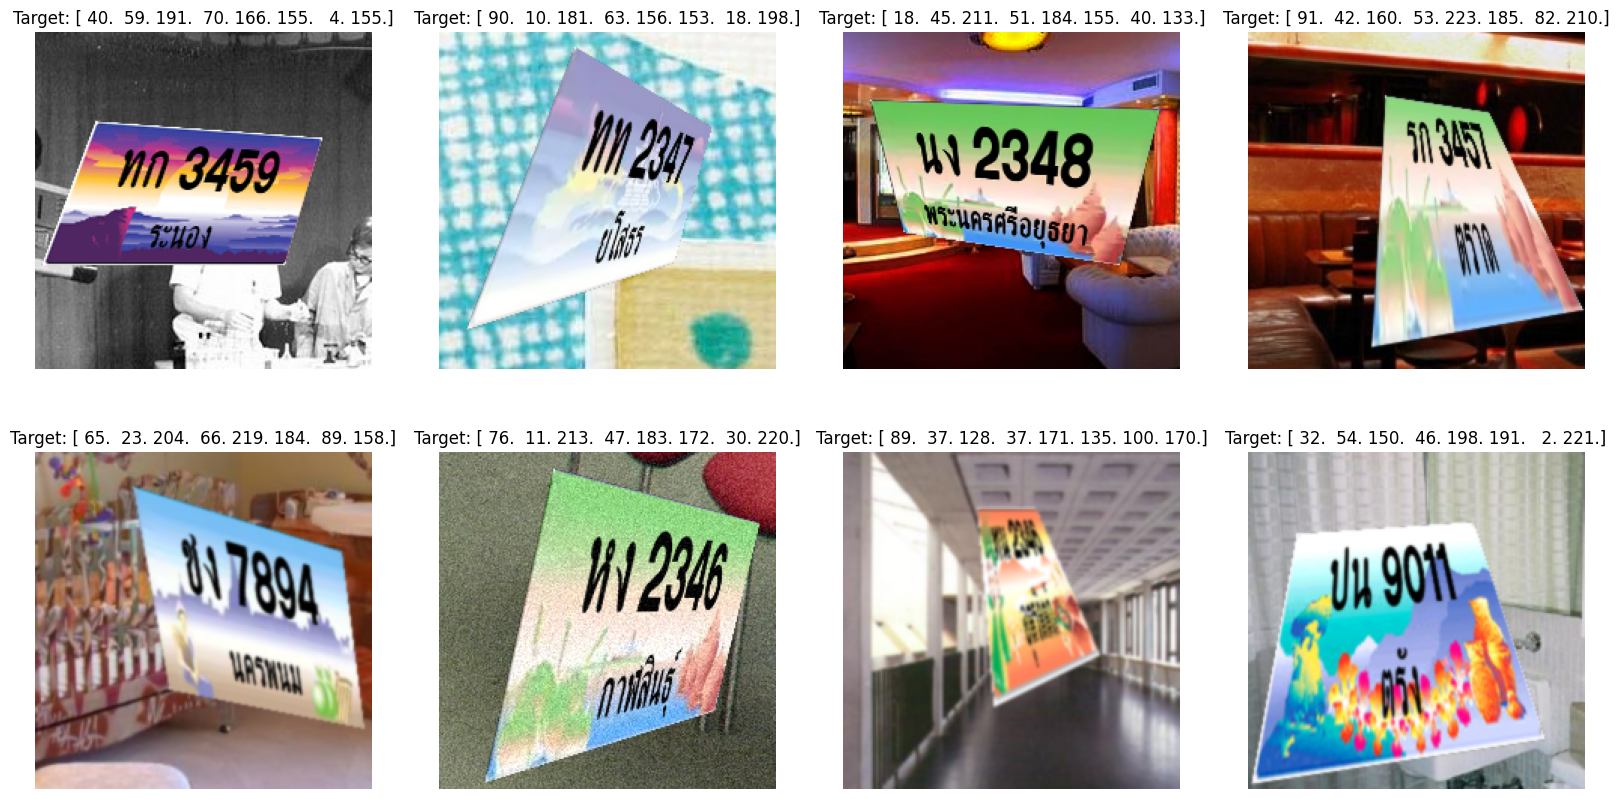

In [7]:
import matplotlib.pyplot as plt

first_batch = next(iter(train_loader))
inputs, targets = first_batch

fig, axs = plt.subplots(2, 4, figsize=(20, 10))

for i, ax in enumerate(axs.ravel()):
    img = inputs[i].permute(1, 2, 0).numpy()
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(f"Target: {targets[i].numpy()}")

plt.show()

In [16]:
def find_homography(src_pts, dst_pts):
  """
  Calculates the homography matrix between two sets of corresponding points.

  Args:
    src_pts: Source points (Nx2 array).
    dst_pts: Destination points (Nx2 array).

  Returns:
    The homography matrix (3x3 array).
  """

  assert src_pts.shape == dst_pts.shape and src_pts.shape[0] >= 4

  A = []
  for i in range(src_pts.shape[0]):
    x, y = src_pts[i]
    u, v = dst_pts[i]
    A.append([x, y, 1, 0, 0, 0, -u * x, -u * y, -u])
    A.append([0, 0, 0, x, y, 1, -v * x, -v * y, -v])

  A = np.array(A)
  _, _, V = np.linalg.svd(A)
  H = V[-1, :].reshape((3, 3))
  H = H / H[2, 2] 

  return H


def apply_homography(image, H):
  """
  Applies a homography transformation to an image.

  Args:
    image: The input image.
    H: The homography matrix.

  Returns:
    The transformed image.
  """

  rows, cols = image.shape[:2]
  new_corners = np.array([[0, 0], [cols - 1, 0], [cols - 1, rows - 1], [0, rows - 1]])
  transformed_corners = cv2.perspectiveTransform(np.array([new_corners]).astype(np.float32), H)
  min_x = np.min(transformed_corners[:, :, 0])
  max_x = np.max(transformed_corners[:, :, 0])
  min_y = np.min(transformed_corners[:, :, 1])
  max_y = np.max(transformed_corners[:, :, 1])

  transformed_image = cv2.warpPerspective(image, H, (int(max_x - min_x), int(max_y - min_y)))
  return transformed_image

def warpPerspective(img, H, output_shape):
    """
    Applies a perspective transformation to an image using a homography matrix with optimized performance.

    Args:
        img: The input image (numpy array).
        H: The 3x3 homography matrix.
        output_shape: The desired shape of the output image (height, width).

    Returns:
        The warped image (numpy array).
    """
    height, width = output_shape

    # Create a grid of (x, y) coordinates in the output image
    x_coords, y_coords = np.meshgrid(np.arange(width), np.arange(height))
    
    # Stack and reshape to form homogeneous coordinates (x, y, 1)
    homogeneous_coords = np.stack([x_coords.ravel(), y_coords.ravel(), np.ones_like(x_coords).ravel()], axis=1)

    # Apply the inverse homography matrix to the coordinates
    src_coords = np.dot(homogeneous_coords, np.linalg.inv(H).T)

    # Normalize homogeneous coordinates to get (x, y)
    src_coords /= src_coords[:, 2][:, np.newaxis]

    # Clip the coordinates to ensure they are within image bounds
    src_x = np.clip(src_coords[:, 0].astype(np.int32), 0, img.shape[1] - 1)
    src_y = np.clip(src_coords[:, 1].astype(np.int32), 0, img.shape[0] - 1)

    # Reshape back to the output image shape
    warped_img = img[src_y, src_x].reshape(height, width, img.shape[2])

    return warped_img

def warp_to_a4(points, input_tensor, dpi=96):
    # A4 dimensions in millimeters and pixels
    A4_WIDTH_MM, A4_HEIGHT_MM = 297, 210
    A4_WIDTH_PIXELS = int((A4_WIDTH_MM / 25.4) * dpi)
    A4_HEIGHT_PIXELS = int((A4_HEIGHT_MM / 25.4) * dpi)

    # Convert the points to a NumPy array and reshape them
    src_pts = np.array(points, dtype=np.float32).reshape(4, 2)

    # Define destination points for an A4 sheet in pixel space
    dst_pts = np.array([
        [0, 0],  # Top-left corner
        [A4_WIDTH_PIXELS - 1, 0],  # Top-right corner
        [A4_WIDTH_PIXELS - 1, A4_HEIGHT_PIXELS - 1],  # Bottom-right corner
        [0, A4_HEIGHT_PIXELS - 1]  # Bottom-left corner
    ], dtype=np.float32)

    # Compute the homography matrix
    H, _ = cv2.findHomography(src_pts, dst_pts)

    # Apply the homography transformation
    result = cv2.warpPerspective(
        input_tensor.squeeze().detach().cpu().numpy().transpose(1, 2, 0), 
        H, 
        (A4_WIDTH_PIXELS, A4_HEIGHT_PIXELS)
    )

    return result

In [ ]:
inputs, targets = first_batch

In [18]:
warp_to_a4(targets[0], inputs[0], dpi=96).shape

(793, 1122, 3)

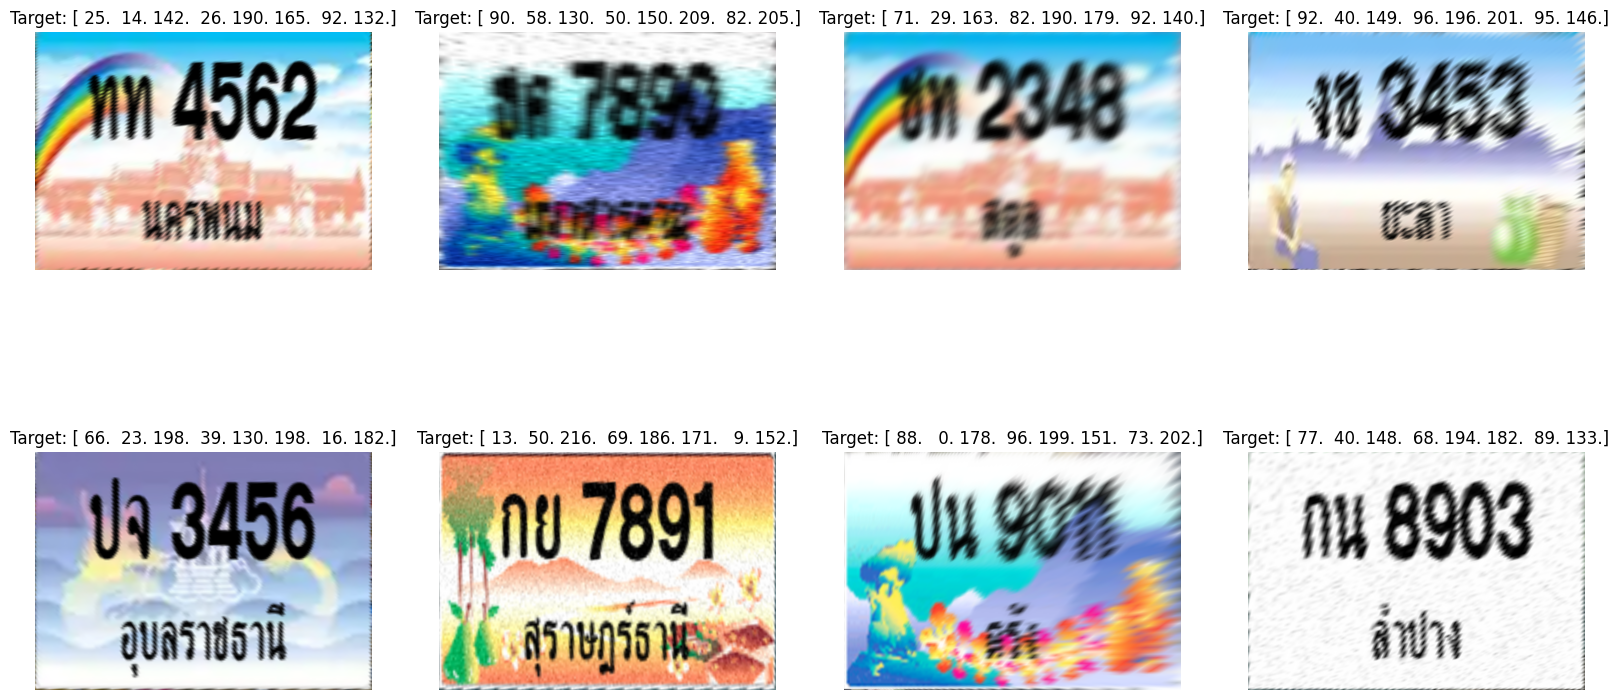

In [22]:
import matplotlib.pyplot as plt

first_batch = next(iter(train_loader))
inputs, targets = first_batch

fig, axs = plt.subplots(2, 4, figsize=(20, 10))

for i, ax in enumerate(axs.ravel()):
    img = warp_to_a4(targets[i], inputs[i], dpi=96)
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(f"Target: {targets[i].numpy()}")

plt.show()

In [24]:
import torch
import cv2
import numpy as np
from torchvision import transforms
import torchvision.models as models
import torch
import torch.nn as nn

class PointEstimatorCNN(nn.Module):
    def __init__(self, input_shape=(3, 224, 224), features=[64, 128, 256, 384, 512, 1024, 2048], dims=[2048], final_dim=8):
        super(PointEstimatorCNN, self).__init__()

        layers = []
        input_channels = input_shape[0]
        for output_channels in features:
            layers.append(nn.Conv2d(input_channels, output_channels, kernel_size=3, padding=1))
            layers.append(nn.BatchNorm2d(output_channels, affine=True))
            layers.append(nn.ReLU())
            layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
            input_channels = output_channels
        
        layers.append(nn.Conv2d(input_channels, 2048, kernel_size=1, padding=1))
        self.features = nn.Sequential(*layers)
        
        self.fc = nn.Sequential(*([nn.Linear(self.get_flatten_dim(input_shape, self.features), final_dim)]))

    def get_flatten_dim(self, input_shape, features):
        x = torch.zeros(1, *input_shape)
        # print(x.shape)
        x = features(x)
        # print(x.shape)
        return x.view(1, -1).size(1)

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

model = PointEstimatorCNN()
model.load_state_dict(torch.load('/mnt/c/Users/teraw/Developer/homography-projects/cp/0.2993_epoch32.pth'))
model.eval()  # Set the model to evaluation mode

/tmp/ipykernel_12737/2709781813.py:41: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/mnt/c/Users/teraw/Developer/homography-projects/cp/0.

PointEstimatorCNN(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_

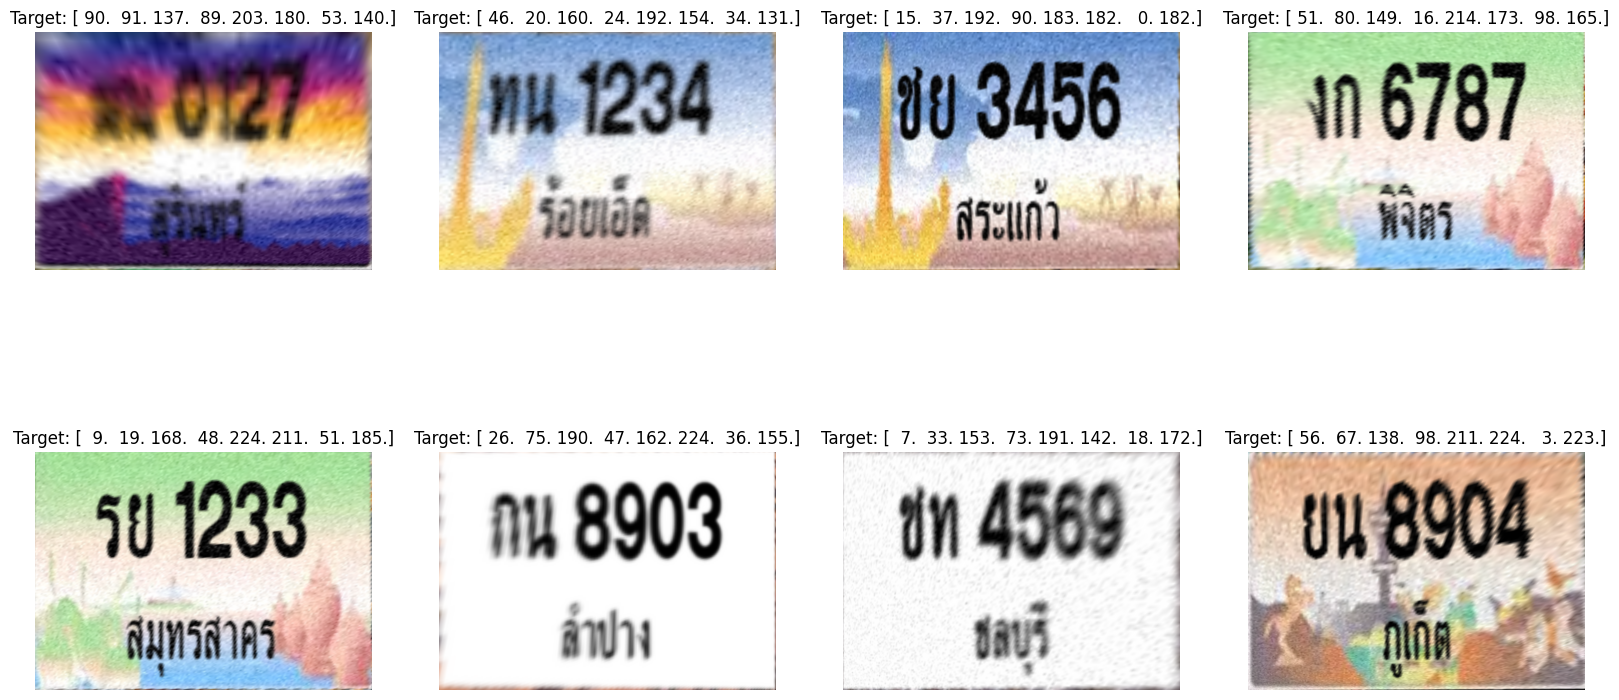

In [30]:
import matplotlib.pyplot as plt

first_batch = next(iter(train_loader))
inputs, targets = first_batch
outputs = model(inputs)
outputs = outputs.detach().numpy()

fig, axs = plt.subplots(2, 4, figsize=(20, 10))

for i, ax in enumerate(axs.ravel()):
    img = warp_to_a4(outputs[i], inputs[i], dpi=96)
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(f"Target: {targets[i].numpy()}")

plt.show()

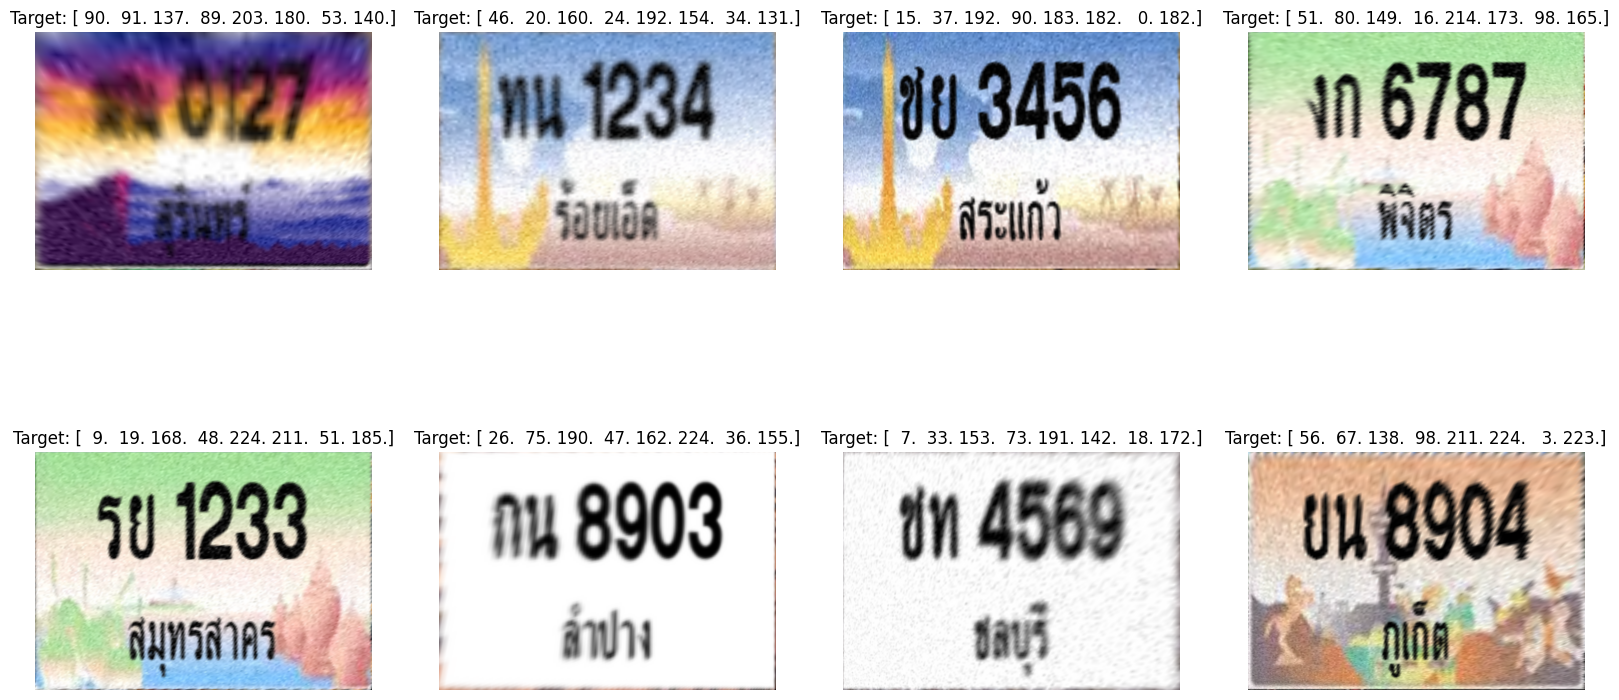

In [31]:
fig, axs = plt.subplots(2, 4, figsize=(20, 10))

for i, ax in enumerate(axs.ravel()):
    img = warp_to_a4(targets[i], inputs[i], dpi=96)
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(f"Target: {targets[i].numpy()}")

plt.show()

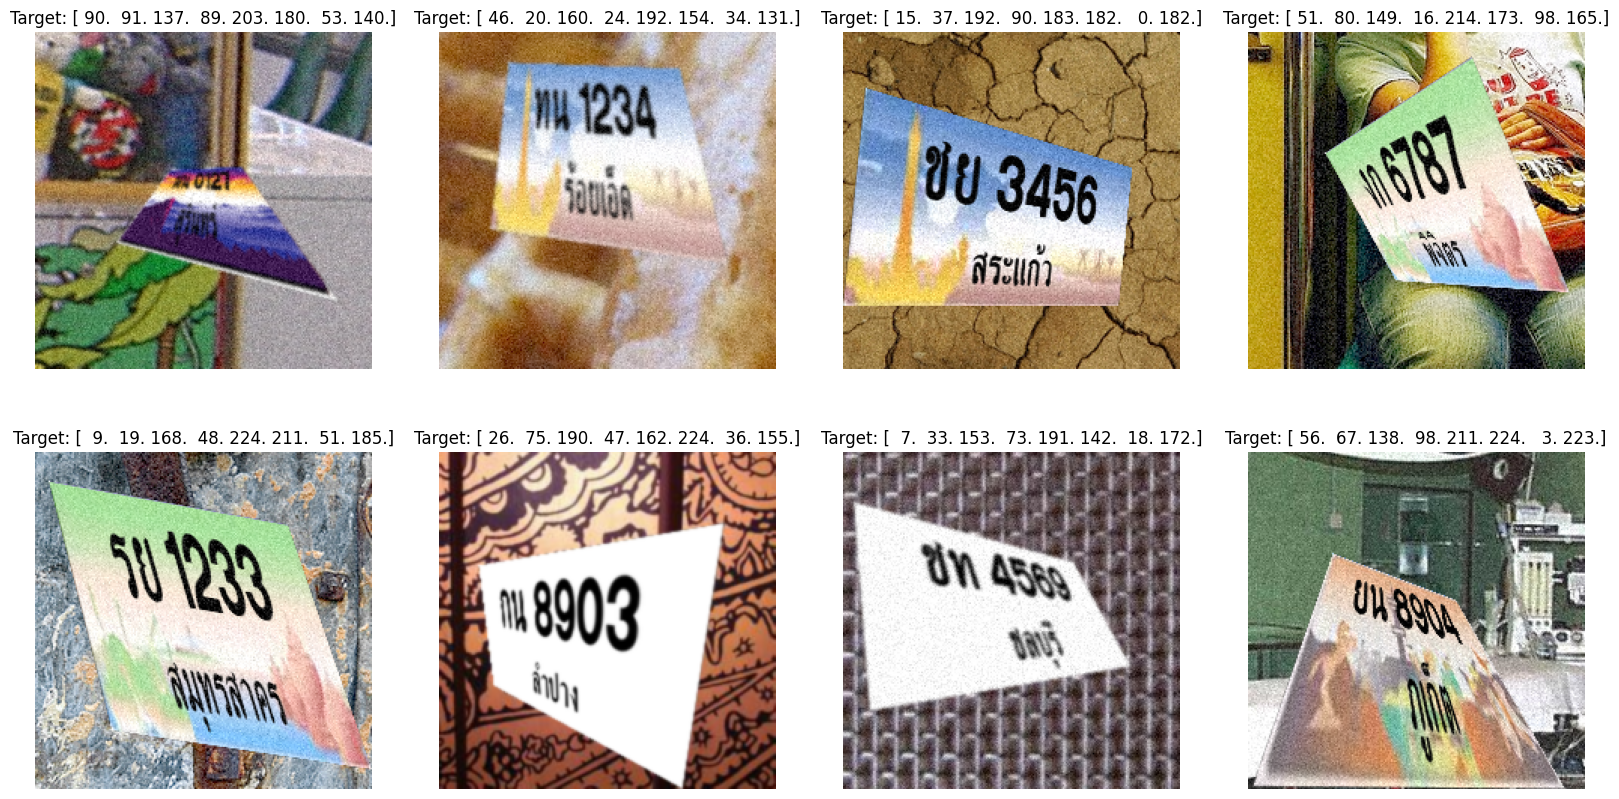

In [32]:
fig, axs = plt.subplots(2, 4, figsize=(20, 10))

for i, ax in enumerate(axs.ravel()):
    img = inputs[i].permute(1, 2, 0).numpy()
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(f"Target: {targets[i].numpy()}")

plt.show()